In [56]:
from pathlib import Path
from scipy.interpolate import interp1d
from magnetopy import DatFile, MvsH
import json
import matplotlib.pyplot as plt

In [86]:
class TrueFieldCorrection(MvsH):
    """
    Corrects magnetic field for flux trapping according to
    https://qdusa.com/siteDocs/appNotes/1500-021.pdf
    """
    def __init__(self, sequence: str | Path):
        dat_file = self._get_dat_file(sequence)
        super().__init__(dat_file)
        self.pd_mass = self._get_mass(dat_file) # mass of the Pd standard in mg
        self._add_true_field()

    def _get_dat_file(self, sequence: str) -> DatFile:
        if Path(sequence).is_file():
            return DatFile(sequence)
        mp_cal = Path().home() / ".magnetopy/calibration"
        if (Path(sequence).suffix == ".dat") and (mp_cal / "calibration_files" / sequence).is_file():
            return DatFile(mp_cal / "calibration_files" / sequence)
        with open(mp_cal / "calibration.json", "r") as f:
            cal_json = json.load(f)
        if (sequence in cal_json['mvsh']):
            seq_dat = cal_json['mvsh'][sequence]
            return DatFile(mp_cal / "calibration_files" / seq_dat)
        raise FileNotFoundError(
            f"Could not find the requested sequence: {sequence}. "
            "TrueFieldCorrection requires either the name of a sequence listed in "
            f"{mp_cal / 'calibration.json'}, the name of a .dat file in "
            f"{mp_cal / 'calibration_files'}, or the path to a .dat file."
        )      
    
    @staticmethod
    def _get_mass(dat_file: DatFile) -> float:
        for line in dat_file.header:
            category = line[0]
            if category != "INFO":
                continue
            info = line[2]
            if info == "SAMPLE_MASS":
                return float(line[1])
        raise ValueError("Could not find the sample mass in the .dat file header.")

    @property
    def forward_fit_values(self):
        # returns [slope, intercept] for the forward scan
        pass

    @property
    def reverse_fit_values(self):
        # returns [slope, intercept] for the reverse scan
        pass

    def _add_true_field(self):
        chi_g = 5.25e-6 # emu Oe / g
        self.data['true_field'] = self.data['uncorrected_moment'] / (chi_g * self.pd_mass * 1e-3)

In [87]:
tf1 = TrueFieldCorrection("sequence_1")
tf2 = TrueFieldCorrection("mvsh_seq1.dat")
tf3 = TrueFieldCorrection("data/Pd_std1.dat")
assert tf1.data.equals(tf2.data)
assert tf1.data.equals(tf3.data)

In [91]:
assert tf1.pd_mass == tf2.pd_mass == tf3.pd_mass
tf1.pd_mass

260.4

In [88]:
# only show columns "Magnetic Field (Oe)" and "true_field"
df = tf1.data[["Temperature (K)", "Magnetic Field (Oe)", "true_field", "uncorrected_moment"]]
df.head()

,Temperature (K),Magnetic Field (Oe),true_field,uncorrected_moment
0,300.045883,-70000.226562,-70226.369299,-0.096006
1,300.093262,-65000.496094,-65225.804911,-0.089170
2,300.121826,-60000.406250,-60202.396541,-0.082303
3,300.117096,-55000.476562,-55185.536611,-0.075444
4,300.133530,-50000.449219,-50167.231972,-0.068584


In [89]:
df[105:115]

,Temperature (K),Magnetic Field (Oe),true_field,uncorrected_moment
105,300.093277,-60.229359,-22.094180,-0.000030
106,300.104935,-50.219650,-13.921277,-0.000019
107,300.071213,-40.197720,-4.185488,-0.000006
108,300.046616,-30.175791,5.743037,0.000008
109,300.100235,-20.141636,16.091112,0.000022
110,300.131439,-10.156371,27.068382,0.000037
111,300.160706,-0.281103,34.869587,0.000048
112,300.175964,10.021931,48.692761,0.000067
113,300.134598,20.068304,56.958691,0.000078
114,300.089279,30.029125,67.471944,0.000092


In [90]:
df[329:339]

,Temperature (K),Magnetic Field (Oe),true_field,uncorrected_moment
329,300.082169,40.197720,4.371114,0.000006
330,300.102127,30.200233,-5.651954,-0.000008
331,300.146805,20.141636,-16.670635,-0.000023
332,300.144958,10.168592,-25.146331,-0.000034
333,300.133438,0.146662,-36.571228,-0.000050
334,300.092514,-9.960821,-45.694056,-0.000062
335,300.039612,-20.007196,-57.472009,-0.000079
336,300.039230,-30.041348,-66.351519,-0.000091
337,300.115707,-39.989948,-76.889775,-0.000105
338,300.198364,-50.048546,-86.621340,-0.000118


In [67]:
df.tail()

,Temperature (K),Magnetic Field (Oe),true_field,uncorrected_moment
440,300.143143,-50000.328125,-50191.739141,-0.068617
441,300.168930,-55000.308594,-55196.804767,-0.075460
442,300.176147,-60000.417969,-60221.633499,-0.082329
443,300.162201,-65000.359375,-65235.582251,-0.089184
444,300.139313,-70000.359375,-70250.492009,-0.096039


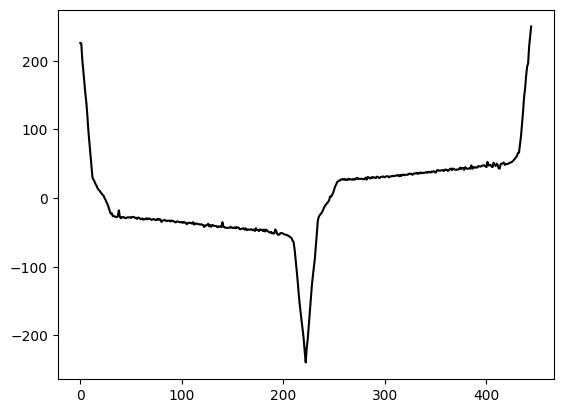

In [62]:
fig, ax = plt.subplots()
x = tf1.data.index
y1 = tf1.data["Magnetic Field (Oe)"]
y2 = tf1.data["true_field"]
# ax.plot(x, y1, c='b')
# ax.plot(x, y2, c='r')
ax.plot(x, y1-y2, c='k')

# ax.plot(x, y2, c='r')

In [52]:
tf1.pd_mass

260.4

In [53]:
tf1.data['uncorrected_moment']

0     -0.096006
1     -0.089170
2     -0.082303
3     -0.075444
4     -0.068584
         ...   
440   -0.068617
441   -0.075460
442   -0.082329
443   -0.089184
444   -0.096039
Name: uncorrected_moment, Length: 445, dtype: float64

In [46]:
dat = DatFile("data/Pd_std1.dat")

In [ ]:
for line in dat.header:
    if 

In [32]:
with open(mp_cal / "calibration.json", "r") as f:
    cj = json.load(f)

cj['mvsh']['sequence_1']


'mvsh_seq1.dat'

In [9]:
mp_cal = Path().home()/ ".magnetopy/calibration"
mp_cal_files = mp_cal / "calibration_files"

In [10]:
# print contents of calibration directory
[print(i) for i in mp_cal.glob("*")]

/home/phil/.magnetopy/calibration/.git
/home/phil/.magnetopy/calibration/README.md
/home/phil/.magnetopy/calibration/calibration_files
/home/phil/.magnetopy/calibration/qd_application_notes
/home/phil/.magnetopy/calibration/calibration.json
/home/phil/.magnetopy/calibration/LICENSE


[None, None, None, None, None, None]

In [11]:
# print contents of calibration files directory
[print(i) for i in mp_cal_files.glob("*")]

/home/phil/.magnetopy/calibration/calibration_files/moment.rw.dat
/home/phil/.magnetopy/calibration/calibration_files/moment.dat
/home/phil/.magnetopy/calibration/calibration_files/mvsh_seq1.dat


[None, None, None]

In [12]:
cal_file = mp_cal_files / "mvsh_seq1.dat"

In [16]:
cal_json = MvsH(cal_file)

In [19]:
cal_json.reverse

,Comment,Time Stamp (sec),Temperature (K),Magnetic Field (Oe),Moment (emu),M. Std. Err. (emu),Transport Action,Averaging Time (sec),Frequency (Hz),Peak Amplitude (mm),Center Position (mm),Lockin Signal' (V),Lockin Signal (V),Range,M. Quad. Signal (emu),AC Moment (emu),AC M. Std Err. (emu),AC Phase (deg),AC Phase Std. Err. (deg),AC Susceptibility (emu/Oe),AC Suscept. Std Err. (emu/Oe),AC X' (emu/Oe),AC X' Std Err. (emu/Oe),AC X'' (emu/Oe),AC X'' Std Err. (emu/Oe),AC Drive (Oe),AC Frequency (Hz),AC Averaging Time (sec),AC Cycles,AC Range,AC Measure Type,AC Signal' (V),AC Signal'' (V),AC Trim Coil Ratio,AC Trim Coil Phase,Min. Temperature (K),Max. Temperature (K),Min. Field (Oe),Max. Field (Oe),Mass (grams),...,Chamber Status (code),Chamber Temp (K),Redirection State,Evercool Status,Average Temp (K),Rotation Angle (deg),Rotator state,DC Moment Fixed Ctr (emu),DC Moment Err Fixed Ctr (emu),DC Moment Free Ctr (emu),DC Moment Err Free Ctr (emu),DC Fixed Fit,DC Free Fit,DC Calculated Center (mm),DC Calculated Center Err (mm),DC Scan Length (mm),DC Scan Time (s),DC Number of Points,DC Squid Drift,DC Min V (V),DC Max V (V),DC Scans per Measure,Map 01,Map 02,Map 03,Map 04,Map 05,Map 06,Map 07,Map 08,Map 09,Map 10,Map 11,Map 12,Map 13,Map 14,Map 15,Map 16,uncorrected_moment,uncorrected_moment_err
0,NaN,3.889454e+09,300.169693,70000.312500,NaN,NaN,6,NaN,NaN,NaN,31.190527,NaN,NaN,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.165436,300.186127,70000.312500,70000.312500,NaN,...,1,300.173950,0,2084575136,300.178958,NaN,NaN,0.096024,0.004790,0.096025,0.004790,0.987344,0.987871,31.204435,NaN,35,4,200,0.003260,-3.762265,0.840959,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.096025,0.004790
1,NaN,3.889454e+09,300.182220,65000.296875,NaN,NaN,6,NaN,NaN,NaN,31.190527,NaN,NaN,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.176880,300.198090,65000.296875,65000.296875,NaN,...,1,300.187561,0,2084574944,300.190289,NaN,NaN,0.089159,0.004447,0.089160,0.004447,0.987484,0.987748,31.200373,0.287591,35,4,200,-0.000803,-3.502558,0.767556,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.089160,0.004447
2,NaN,3.889454e+09,300.124237,60000.148438,NaN,NaN,6,NaN,NaN,NaN,31.190527,NaN,NaN,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.116119,300.134430,60000.148438,60000.148438,NaN,...,1,300.116119,0,2084574912,300.128787,NaN,NaN,0.082307,0.004105,0.082307,0.004105,0.987618,0.987707,31.196209,3.709754,35,4,200,-0.002044,-3.236768,0.710557,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.082307,0.004105
3,NaN,3.889454e+09,300.138992,55000.347656,NaN,NaN,6,NaN,NaN,NaN,31.190527,NaN,NaN,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.123688,300.159485,55000.347656,55000.347656,NaN,...,1,300.154297,0,2084574720,300.148444,NaN,NaN,0.075446,0.003763,0.075446,0.003763,0.987717,0.987726,31.192410,0.000003,35,4,200,-0.002234,-2.966620,0.652215,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.075446,0.003763
4,NaN,3.889454e+09,300.128281,50000.476562,NaN,NaN,6,NaN,NaN,NaN,31.190527,NaN,NaN,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.124359,300.145416,50000.476562,50000.476562,NaN,...,1,300.132202,0,2084574912,300.137537,NaN,NaN,0.068584,0.003421,0.068584,0.003421,0.987714,0.987718,31.189297,5.584738,35,4,200,-0.002771,-2.695719,0.593288,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.068584,0.003421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,NaN,3.889460e+09,300.143143,-500